In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, chisquare
from bettools import generate_seasons, get_data

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.mode.chained_assignment = None 

leagues = ['E0','E1','E2','E3','S0','SC0','SC1','SC2','SC3']

seasons = generate_seasons(2012, 2024)

df_ls = get_data(seasons, leagues)

In [2]:
rated_ls = []

for main_df in df_ls:
    main_df['P_margin'] = (1/main_df['PSH'] + 1/main_df['PSD'] + 1/main_df['PSA']) - 1
    
    main_df['fair_PSH'] = (3 * main_df['PSH'])/(3 - main_df['P_margin']*main_df['PSH'])
    main_df['fair_PSD'] = (3 * main_df['PSD'])/(3 - main_df['P_margin']*main_df['PSD'])
    main_df['fair_PSA'] = (3 * main_df['PSA'])/(3 - main_df['P_margin']*main_df['PSA'])
    
    main_df['check_col'] = 1/main_df['fair_PSH'] + 1/main_df['fair_PSD'] + 1/main_df['fair_PSA']
    
    ratings = {}
    
    for i in range(len(main_df)):
        home_team = main_df.loc[i]['HomeTeam']
        away_team = main_df.loc[i]['AwayTeam']
    
        if home_team in ratings:
            home_team_prior_rating = ratings[home_team]
        else:
            home_team_prior_rating = 0
            
        if away_team in ratings:
            away_team_prior_rating = ratings[away_team]
        else:
            away_team_prior_rating = 0
    
        main_df.loc[i,'home_team_prior_rating'] = home_team_prior_rating
        main_df.loc[i,'away_team_prior_rating'] = away_team_prior_rating
    
        match_rating = away_team_prior_rating - home_team_prior_rating
    
        main_df.loc[i,'match_rating'] = match_rating
    
        if main_df.loc[i]['FTHG']>main_df.loc[i]['FTAG']:
            home_team_post_rating = home_team_prior_rating + (1 - 1/main_df.loc[i]['fair_PSH'])
        else:
            home_team_post_rating = home_team_prior_rating + (-1/main_df.loc[i]['fair_PSH'])
    
        if main_df.loc[i]['FTHG']<main_df.loc[i]['FTAG']:
            away_team_post_rating = away_team_prior_rating + (1 - 1/main_df.loc[i]['fair_PSA'])
        else:
            away_team_post_rating = away_team_prior_rating + (-1/main_df.loc[i]['fair_PSA'])
        main_df.loc[i,'away_team_post_rating'] = away_team_post_rating
        
        ratings[home_team] = home_team_post_rating
        ratings[away_team] = away_team_post_rating

    THRESH = 0

    bet_df = main_df[abs(main_df['match_rating'])>THRESH]
    
    home_bet_df = bet_df[bet_df['match_rating']>0]
    home_bet_df['prediction'] = 'H'
    away_bet_df = bet_df[bet_df['match_rating']<0]
    away_bet_df['prediction'] = 'A'
    
    home_bet_df['win'] = np.where(home_bet_df['FTHG']>home_bet_df['FTAG'],1,0)
    
    # home_bet_df['stake'] = 1/home_bet_df['fair_PSH']
    home_bet_df['stake'] = 1
    home_bet_df['profit'] = (home_bet_df['stake'] * home_bet_df['home_max_odds'] * home_bet_df['win']) - home_bet_df['stake']
    
    away_bet_df['win'] = np.where(away_bet_df['FTHG']<away_bet_df['FTAG'],1,0)
    
    # away_bet_df['stake'] = 1/away_bet_df['fair_PSA']
    away_bet_df['stake'] = 1
    away_bet_df['profit'] = (away_bet_df['stake'] * away_bet_df['away_max_odds'] * away_bet_df['win']) - away_bet_df['stake']
    
    result_df = pd.concat([home_bet_df, away_bet_df])
    
    result_df = result_df.sort_values('Date')
    
    result_df.reset_index(drop=True, inplace=True)

    rated_ls.append(result_df)

In [3]:
final_df = pd.concat(rated_ls)

final_df = final_df.sort_values('Date')
final_df.reset_index(drop=True, inplace=True)

final_df

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,PSH,PSD,PSA,home_max_odds,away_max_odds,draw_max_odds,P_margin,fair_PSH,fair_PSD,fair_PSA,check_col,home_team_prior_rating,away_team_prior_rating,match_rating,away_team_post_rating,prediction,win,stake,profit
0,SC0,2012-08-11,Motherwell,St Johnstone,1.0,1.0,2.24,3.38,3.53,2.25,3.90,3.38,0.025573,2.283604,3.480273,3.639515,1.0,-0.351829,-0.243963,0.107867,-0.518725,H,0,1,-1.00
1,SC0,2012-08-11,Aberdeen,Ross County,0.0,0.0,2.00,3.45,4.25,2.00,4.30,3.45,0.025149,2.034104,3.552751,4.407013,1.0,-0.070813,-0.355753,-0.284941,-0.582664,A,0,1,-1.00
2,SC0,2012-08-11,Dundee,St Mirren,0.0,2.0,2.68,3.29,2.88,2.68,2.88,3.29,0.024308,2.739488,3.380106,2.948812,1.0,-0.245508,-0.413444,-0.167936,0.247437,A,1,1,1.88
3,SC0,2012-08-11,Inverness C,Kilmarnock,1.0,1.0,2.29,3.40,3.38,2.38,3.38,3.40,0.026657,2.337565,3.505918,3.484656,1.0,-0.299195,-0.479506,-0.180310,-0.766478,A,0,1,-1.00
4,SC0,2012-08-11,Motherwell,St Johnstone,1.0,1.0,2.24,3.38,3.53,2.25,3.90,3.38,0.025573,2.283604,3.480273,3.639515,1.0,-0.351829,-0.243963,0.107867,-0.518725,H,0,1,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30370,E0,2024-04-24,Man United,Sheffield United,4.0,2.0,1.32,6.28,8.27,1.32,8.50,6.50,0.037730,1.342284,6.818545,9.230015,1.0,1.018922,-2.316125,-3.335046,-2.424467,A,0,1,-1.00
30371,E0,2024-04-24,Wolves,Bournemouth,0.0,1.0,2.74,3.53,2.60,2.74,2.60,3.70,0.032865,2.824791,3.672001,2.676227,1.0,2.336144,0.229229,-2.106915,0.855569,A,1,1,1.60
30372,E0,2024-04-24,Crystal Palace,Newcastle,2.0,0.0,2.76,3.70,2.49,2.76,2.49,3.70,0.034196,2.849650,3.862917,2.562736,1.0,-0.565757,0.605743,1.171500,0.215535,H,1,1,1.76
30373,E0,2024-04-24,Everton,Liverpool,2.0,0.0,7.49,5.00,1.42,7.49,1.43,5.00,0.037737,8.269079,5.335579,1.445825,1.0,-0.785677,1.214925,2.000602,0.523278,H,1,1,6.49


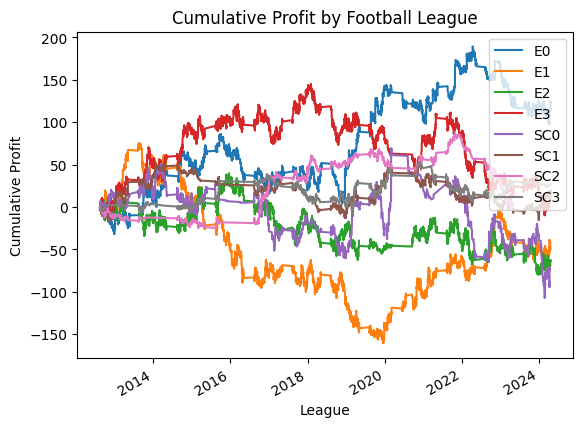

In [4]:
THRESH = 0

final_df = pd.concat(rated_ls)

final_df = final_df.sort_values('Date')
final_df.reset_index(drop=True, inplace=True)

final_df = final_df[abs(final_df['match_rating'])>THRESH]

final_df.reset_index(inplace=True, drop=True)

final_df['c_profit'] = final_df['profit'].cumsum()

final_df['div_c_profit'] = final_df.groupby('Div')['profit'].cumsum()

fig, ax = plt.subplots()

for league, data in final_df.groupby('Div'):
    data.plot(x='Date', y='div_c_profit', ax=ax, label=league)

plt.title('Cumulative Profit by Football League')
plt.xlabel('League')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()

<Axes: >

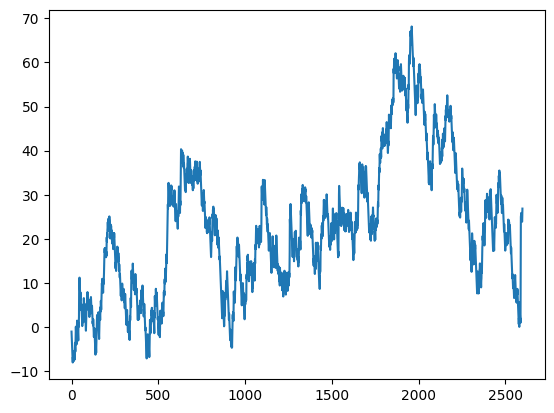

In [18]:
THRESH_MIN = 3
THRESH_MAX = 5

final_df = pd.concat(rated_ls)

exclude_list = ['I2','I1']
final_df = final_df[~final_df['Div'].isin(exclude_list)]

final_df = final_df[final_df['prediction']=='H']

final_df = final_df.sort_values('Date')
final_df.reset_index(drop=True, inplace=True)

final_df = final_df[(abs(final_df['match_rating'])>THRESH_MIN)&(abs(final_df['match_rating'])<THRESH_MAX)]

final_df.reset_index(inplace=True, drop=True)

final_df['c_profit'] = final_df['profit'].cumsum()

final_df['c_profit'].plot()

In [ ]:
THRESH = 0

bet_df = main_df[abs(main_df['match_rating'])>THRESH]

home_bet_df = bet_df[bet_df['match_rating']>0]
home_bet_df['prediction'] = 'H'
away_bet_df = bet_df[bet_df['match_rating']<0]
away_bet_df['prediction'] = 'A'

home_bet_df['win'] = np.where(home_bet_df['FTHG']>home_bet_df['FTAG'],1,0)

home_bet_df['stake'] = 1/home_bet_df['fair_PSH']
home_bet_df['profit'] = (home_bet_df['stake'] * home_bet_df['PSH'] * home_bet_df['win']) - home_bet_df['stake']

away_bet_df['win'] = np.where(away_bet_df['FTHG']<away_bet_df['FTAG'],1,0)

away_bet_df['stake'] = 1/away_bet_df['fair_PSA']
away_bet_df['profit'] = (away_bet_df['stake'] * away_bet_df['PSA'] * away_bet_df['win']) - away_bet_df['stake']

result_df = pd.concat([home_bet_df, away_bet_df])

result_df = result_df.sort_values('Date')

result_df.reset_index(drop=True, inplace=True)

result_df['c_profit'] = result_df['profit'].cumsum()

result_df['c_profit'].plot()